In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning /Datasets/Monthly_Milk_Production.csv', index_col='Month', parse_dates=True)
df.index.freq='MS'

In [4]:
df.head()

,Milk Production
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [5]:
df.tail()

,Milk Production
Month,
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0
1975-11-01,797.0
1975-12-01,843.0


<Axes: xlabel='Month'>

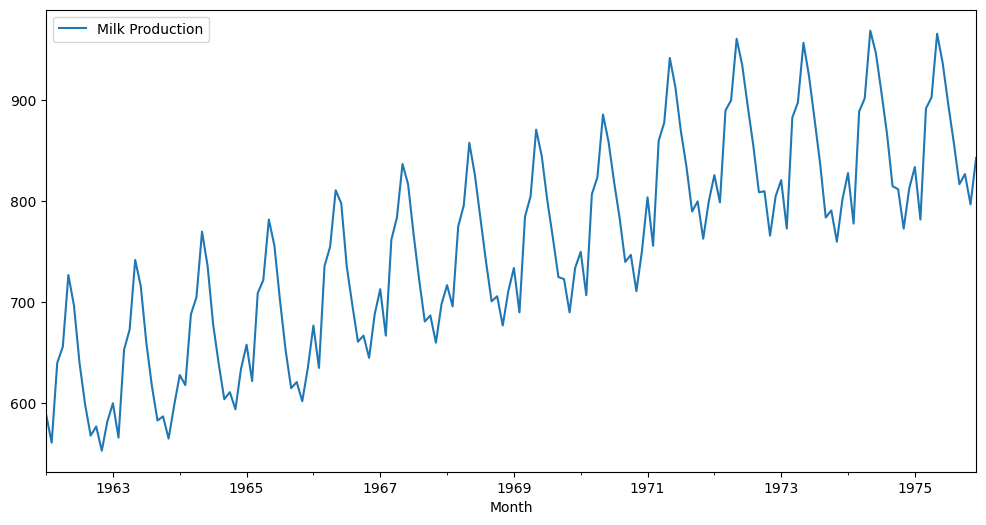

In [6]:
df.plot(figsize=(12,6))

<font size = 5> <font color = yellow> This is a Time-Series data. Where the values(Milk production: pounds per cow) varies with time(every month). This is a repeatative pattern. We can see the same pattern repeating with just change in value along y-axis. It is called seasonality in terms of time-series analysis. Seasonality means this repeatative pattern. Let's see some more properties of this time-series data.

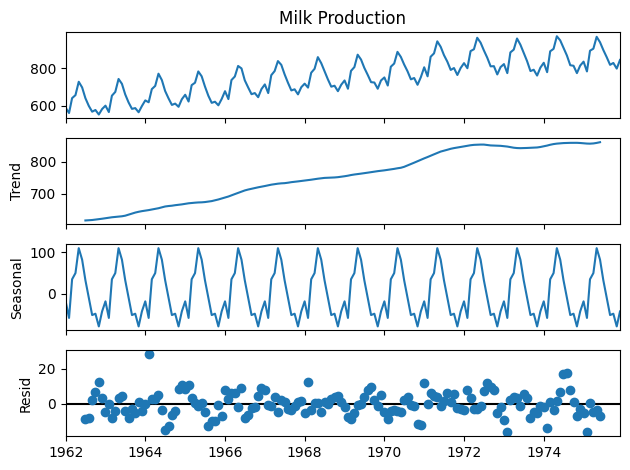

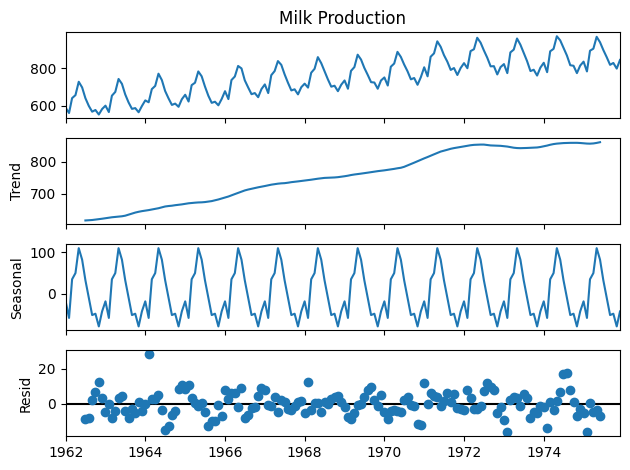

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['Milk Production'])
results.plot()    # First plot is the observed plot. The plot we just plotted before this cell. Residual is basically noise. If we exclude Trend and Seasonal then what left is the Residual values.
                  # Residual does not follow any patterns. So it can be considered as noise.

In [8]:
len(df)

168

In [9]:
train = df.iloc[:144] # Out of 168 months, first 144 (from index 0 to 143) months data has been taken as train data.

test = df.iloc[144:]  # Last 24 month's data (starting from index 144 to last index 167) has been taken as test data.

<font size = 5> <font color = lime> The Milk Production's values are very high value (589, 640, 727 ....). So, before fitting them into Neural network, we have to scale them.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # scaler is an instance or object of MinMaxScaler().

In [11]:
df.head(), df.tail()

(            Milk Production
 Month                      
 1962-01-01            589.0
 1962-02-01            561.0
 1962-03-01            640.0
 1962-04-01            656.0
 1962-05-01            727.0,
             Milk Production
 Month                      
 1975-08-01            858.0
 1975-09-01            817.0
 1975-10-01            827.0
 1975-11-01            797.0
 1975-12-01            843.0)

In [12]:
scaler.fit(train)                      # scaler.fit will calculate the mean, standard deviation etc.
scaled_train = scaler.transform(train) # then scaler.transform will apply those (mean, standard deviation etc.) on our train data
scaled_test = scaler.transform(test)   # same thing we will do with our test data

In [13]:
scaled_train[:10]

array([[0.08823529],
       [0.01960784],
       [0.21323529],
       [0.25245098],
       [0.42647059],
       [0.35294118],
       [0.21323529],
       [0.1127451 ],
       [0.03676471],
       [0.05882353]])

In [ ]:
'''from keras.preprocessing.sequence import TimeseriesGenerator # This TimeseriesGenerator is depricated in lastest version.

# Define Generator
n_input = 3  # considers 3 month's data. then will predict the next month's data based on these 3 month's data.
n_features = 1 # feature means how many time-series are there.
generator = TimeseriesGenerator(scaled_train, scaled_train, lenght = n_input, batchsize=1)

X, y = generator[0]
print(f'Given the Array : \n{X.flatten()}')
print(f'Predict this y : \n'{y})'''

"from keras.preprocessing.sequence import TimeseriesGenerator\n\n# Define Generator\nn_input = 3  # considers 3 month's data. then will predict the next month's data based on these 3 month's data.\nn_features = 1 # feature means how many time-series are there.\ngenerator = TimeseriesGenerator(scaled_train, scaled_train, lenght = n_input, batchsize=1)\n\nX, y = generator[0]\nprint(f'Given the Array : \n{X.flatten()}')\nprint(f'Predict this y : \n'{y})"

<font size = 5> <font color = cyan> TimeseriesGenerator makes our data suitable to fit in our RNN or LSTM model. Since TimeseriesGenerator was a function in the keras.preprocessing.sequence module, which has been deprecated. So now, I have to implement the process alternatively.

In [14]:
def create_sequences(data, n_input):
    X, y = [], []                      # X is input, y is prediction.
    for i in range(len(data) - n_input):
        seq_x = data[i:i+n_input]      # take n_input values
        seq_y = data[i+n_input]        # the next value is the target
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [15]:
n_input = 3 # 3 months data will predict the 4th month's milk production
n_features = 1

X_train, y_train = create_sequences(scaled_train, n_input)
X_test, y_test = create_sequences(scaled_test, n_input)

# reshape for LSTM/GRU (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(f"Given the Array : \n{X_train[0].flatten()}")  # If we provide data for Jan, Feb, Mar then it will predict for April. In next iterations Feb, Mar, April data will be given and it will predict for May!
print(f"Predict this y : \n{y_train[0]}")

Given the Array : 
[0.08823529 0.01960784 0.21323529]
Predict this y : 
[0.25245098]


<font size = 5> <font color = orange> The previous 2 code cell does exactly what TimeseriesGenerator used to do:

<font size = 5> <font color = red> (i) Takes a sliding window of length n_input from my scaled data.

<font size = 5> <font color = red> (ii) Uses the next value as the target.

<font size = 5> <font color = red>(iii) Reshapes for recurrent models (LSTM, GRU, RNN).

In [16]:
X_train.shape

(141, 3, 1)

In [17]:
print(len(scaled_test))

24


<font size = 5> <font color = lime> Let's do the same thing for 12 Months now!

In [18]:
n_input = 12
n_features = 1

X_train, y_train = create_sequences(scaled_train, n_input)
X_test, y_test = create_sequences(scaled_test, n_input)

# reshape for LSTM/GRU (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM

<font size = 6> <font color = red> Define/Create Model

In [20]:
# Define Model
model = Sequential()
model.add(Input(shape=(n_input, n_features)))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

<font size = 6> <font color = lime> Model Training

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),  # monitor validation loss (optional)
    verbose=1
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.2234 - val_loss: 0.1638
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0655 - val_loss: 0.0310
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0426 - val_loss: 0.0384
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0332 - val_loss: 0.0296
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0298 - val_loss: 0.0508
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0356 - val_loss: 0.0432
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0301 - val_loss: 0.0273
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0248 - val_loss: 0.0221
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0248 - val_loss: 0.0220
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0257 - val_loss: 0.0220
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0280 - val_loss: 0.0231
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0262 - val_loss: 0.0224
E

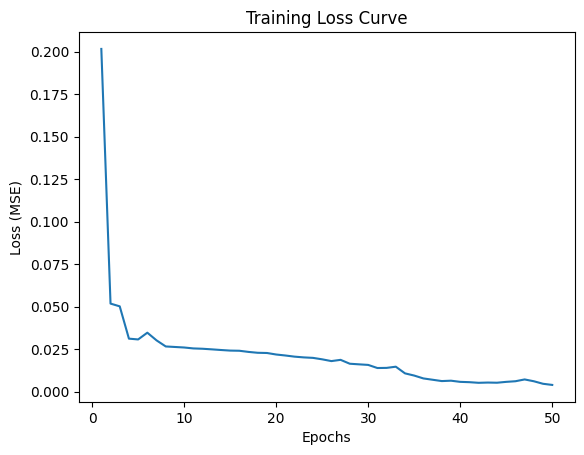

In [27]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(1, len(loss_per_epoch) + 1), loss_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Curve")
plt.show()

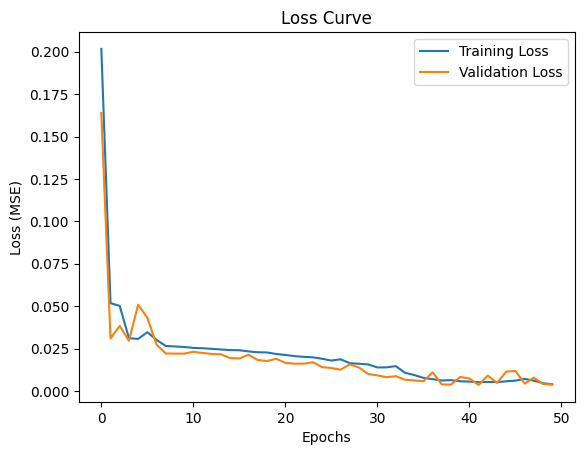

In [28]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Loss Curve")
plt.legend()
plt.show()


In [29]:
last_train_batch = scaled_train[-24:]

In [30]:
last_train_batch = last_train_batch.reshape(2, n_input, n_features)

In [31]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


array([[0.6612142],
       [0.6420926]], dtype=float32)

In [32]:
scaled_test[0]

array([0.67401961])

In [33]:
test_predictions = []

n_input = 12   # 12 months of data to predict the next month
n_features = 1 # univariate series

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input,n_features))

for i in range(len(test)):
# get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

# append the prediction into the array
    test_predictions.append(current_pred)

# use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [34]:
test_predictions

[array([0.6420925], dtype=float32),
 array([0.6965073], dtype=float32),
 array([0.81495154], dtype=float32),
 array([0.882049], dtype=float32),
 array([0.92976177], dtype=float32),
 array([0.8976128], dtype=float32),
 array([0.8248928], dtype=float32),
 array([0.73374623], dtype=float32),
 array([0.6527045], dtype=float32),
 array([0.61974984], dtype=float32),
 array([0.6029638], dtype=float32),
 array([0.6430408], dtype=float32),
 array([0.6880379], dtype=float32),
 array([0.7535719], dtype=float32),
 array([0.82858044], dtype=float32),
 array([0.8827785], dtype=float32),
 array([0.9094673], dtype=float32),
 array([0.8924386], dtype=float32),
 array([0.8405021], dtype=float32),
 array([0.771289], dtype=float32),
 array([0.7097829], dtype=float32),
 array([0.67478013], dtype=float32),
 array([0.666727], dtype=float32),
 array([0.68989307], dtype=float32)]

In [35]:
test.head()

,Milk Production
Month,
1974-01-01,828.0
1974-02-01,778.0
1974-03-01,889.0
1974-04-01,902.0
1974-05-01,969.0


In [36]:
df.tail(24)

,Milk Production
Month,
1974-01-01,828.0
1974-02-01,778.0
1974-03-01,889.0
1974-04-01,902.0
1974-05-01,969.0
1974-06-01,947.0
1974-07-01,908.0
1974-08-01,867.0
1974-09-01,815.0


In [37]:
test.columns

Index(['Milk Production'], dtype='object')

In [38]:
true_predictions = scaler.inverse_transform(test_predictions)

In [39]:
pred_df = pd.DataFrame(
    true_predictions,
    index=test.index,
    columns=["Predicted"]
)

<font size = 6> <font color = lime> Plot Actual vs Predicted

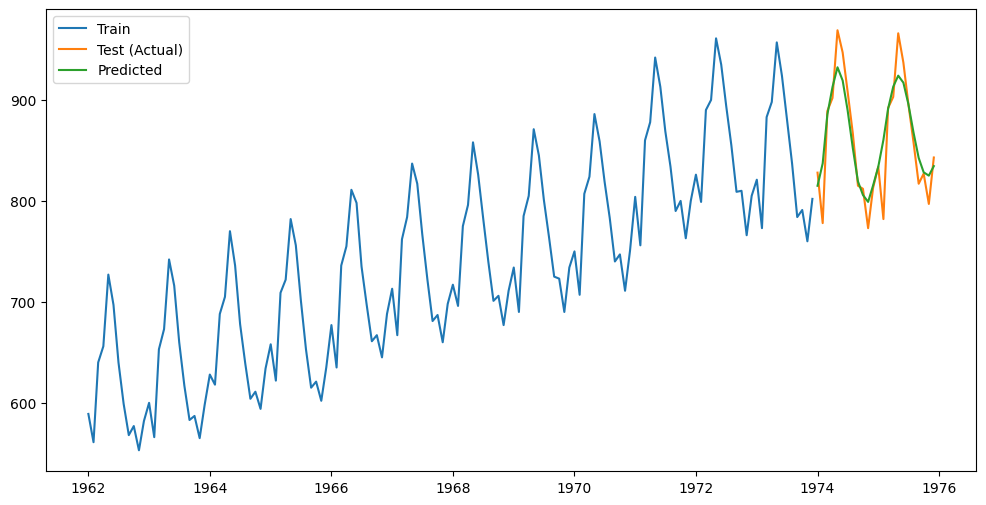

In [40]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test (Actual)")
plt.plot(pred_df.index, pred_df["Predicted"], label="Predicted")
plt.legend()
plt.show()

<font size = 6> <font color = red> Evaluate the Model

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt                              # Root Mean Squared Error calculation
rmse = sqrt(mean_squared_error(test['Milk Production'], pred_df['Predicted']))
print(f"RMSE : {rmse:.5f}")

RMSE : 26.79572


In [44]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

# MAE
mae = mean_absolute_error(test['Milk Production'], pred_df['Predicted'])

# MAPE              # Mean Absolute Percentage Error
mape = np.mean(np.abs((test['Milk Production'] - pred_df['Predicted']) / test['Milk Production'])) * 100

print(f"MAE : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

MAE: 18.66
MAPE: 2.20%
